In [35]:
import zipfile

# unzipping the dataset
zip_path = '/content/drive/MyDrive/summer2winter.zip'
extract_path = '/content/dataset'

# Extraction
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# varifying
import os
extracted_files = os.listdir(extract_path)
print("Extracted files:", extracted_files)


Extracted files: ['metadata.csv', 'trainB', 'trainA', 'testB', 'testA']


In [36]:
import os
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# normal preprocessing
def load_image(file_path):
    image = load_img(file_path)
    image = img_to_array(image)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1.0
    return image

def load_dataset(directory):
    files = glob.glob(os.path.join(directory, '*'))
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(lambda x: tf.numpy_function(load_image, [x], tf.float32))
    dataset = dataset.batch(1)
    return dataset

# Creating datasets
trainA_dataset = load_dataset(os.path.join(extract_path, 'trainA'))
trainB_dataset = load_dataset(os.path.join(extract_path, 'trainB'))
testA_dataset = load_dataset(os.path.join(extract_path, 'testA'))
testB_dataset = load_dataset(os.path.join(extract_path, 'testB'))


In [37]:
import tensorflow as tf
from tensorflow.keras import layers

# defining the cycleGAN model.
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        layers.Conv2D(64, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(128, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(256, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2D(512, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU()
    ]

    up_stack = [
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU()
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs
    for down in down_stack:
        x = down(x)
    for up in up_stack:
        x = up(x)
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    tar = layers.Input(shape=[256, 256, 3], name='target_image')
    x = layers.concatenate([inp, tar])
    down1 = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    down1 = layers.LeakyReLU()(down1)
    down2 = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)
    down3 = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)
    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(batchnorm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

# Instantiate the models
G_A2B = build_generator()
G_B2A = build_generator()
D_A = build_discriminator()
D_B = build_discriminator()



In [46]:
import tensorflow as tf
import time

# Defining loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, lambda_cycle=10):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_cycle * loss1

def identity_loss(real_image, same_image, lambda_identity=5):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_identity * loss

# Define the optimizers
generator_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training function
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = G_A2B(real_x, training=True)
        cycled_x = G_B2A(fake_y, training=True)

        fake_x = G_B2A(real_y, training=True)
        cycled_y = G_A2B(fake_x, training=True)

        same_x = G_B2A(real_x, training=True)
        same_y = G_A2B(real_y, training=True)

        disc_real_x = D_A([real_x, real_y], training=True)
        disc_real_y = D_B([real_y, real_x], training=True)

        disc_fake_x = D_A([fake_x, real_y], training=True)
        disc_fake_y = D_B([fake_y, real_x], training=True)

        gen_G_loss = generator_loss(disc_fake_y)
        gen_F_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    generator_G_gradients = tape.gradient(total_gen_G_loss, G_A2B.trainable_variables)
    generator_F_gradients = tape.gradient(total_gen_F_loss, G_B2A.trainable_variables)

    discriminator_X_gradients = tape.gradient(disc_X_loss, D_A.trainable_variables)
    discriminator_Y_gradients = tape.gradient(disc_Y_loss, D_B.trainable_variables)

    generator_G_optimizer.apply_gradients(zip(generator_G_gradients, G_A2B.trainable_variables))
    generator_F_optimizer.apply_gradients(zip(generator_F_gradients, G_B2A.trainable_variables))

    discriminator_X_optimizer.apply_gradients(zip(discriminator_X_gradients, D_A.trainable_variables))
    discriminator_Y_optimizer.apply_gradients(zip(discriminator_Y_gradients, D_B.trainable_variables))

# Training loop
num_epochs = 1  # 1 me hi bohot time le rha hai XD

for epoch in range(num_epochs):
    start_time = time.time()

    for real_x, real_y in tf.data.Dataset.zip((trainA_dataset, trainB_dataset)):
        train_step(real_x, real_y)

    end_time = time.time()
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {end_time - start_time:.2f}s")

    # saving progress
    if (epoch + 1) % save_interval == 0:
        G_A2B.save(f'G_A2B_epoch_{epoch+1}.h5')
        G_B2A.save(f'G_B2A_epoch_{epoch+1}.h5')
        D_A.save(f'D_A_epoch_{epoch+1}.h5')
        D_B.save(f'D_B_epoch_{epoch+1}.h5')
        print(f"Models saved at epoch {epoch+1}")


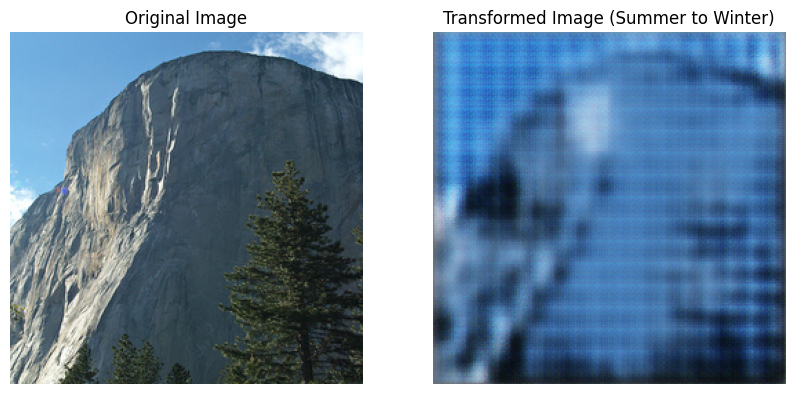

In [47]:
import matplotlib.pyplot as plt

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    image = load_img(image_path)
    image = img_to_array(image)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1.0
    image = tf.expand_dims(image, 0)  # Add batch dimension
    return image

# Function to plot images
def plot_images(original, transformed, title):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow((original[0] * 0.5) + 0.5)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow((transformed[0] * 0.5) + 0.5)
    axs[1].set_title(title)
    axs[1].axis('off')

    plt.show()

# Load a sample image from the test set
test_image_path = '/content/dataset/testA/2011-05-23 17_46_40.jpg'
original_image = load_and_preprocess_image(test_image_path)

# Transform the image using the trained generator
fake_image = G_A2B(original_image, training=False)

# Plot the original and transformed images
plot_images(original_image, fake_image, 'Transformed Image (Summer to Winter)')
